<a href="https://colab.research.google.com/github/AlisionXue/Machine-learning-Finial-Project/blob/main/Finial_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⏳ Downloading dataset...
Dataset URL: https://www.kaggle.com/datasets/brandao/diabetes
License(s): CC0-1.0
✅ Dataset download completed!

=== Data loaded successfully ===
📊 Data shape: (101766, 50)
🔍 First 5 rows preview:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1         

<ipython-input-1-6d5921819b1b>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_features] = X[categorical_features].astype(str)



=== Model Training ===

🚀 Training Logistic Regression...


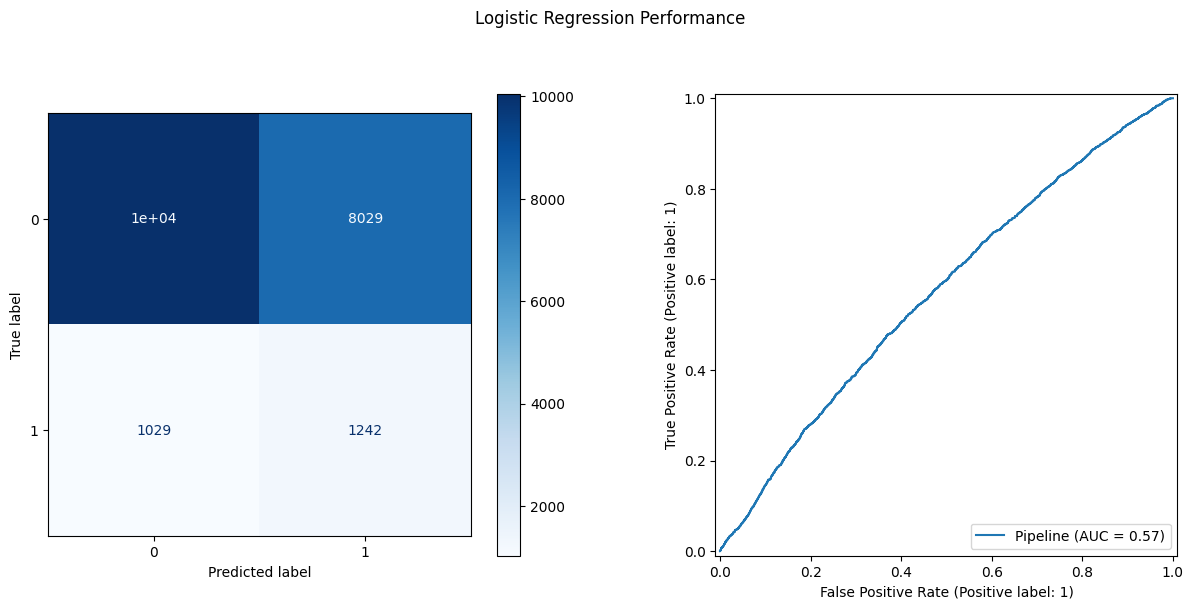


🚀 Training Random Forest...


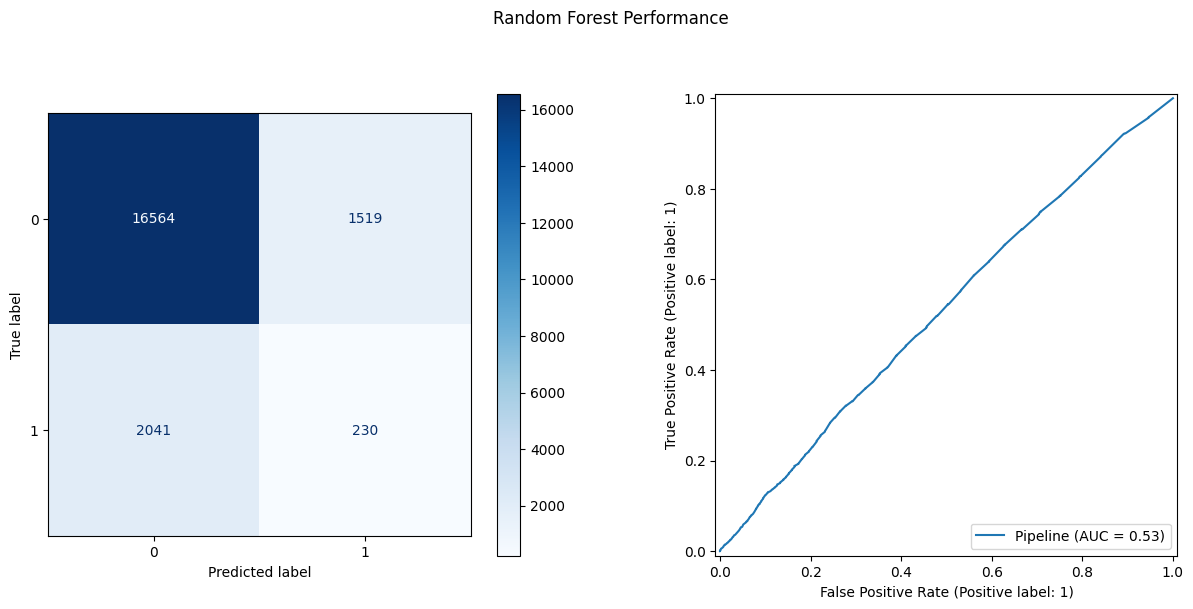


🚀 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:57:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


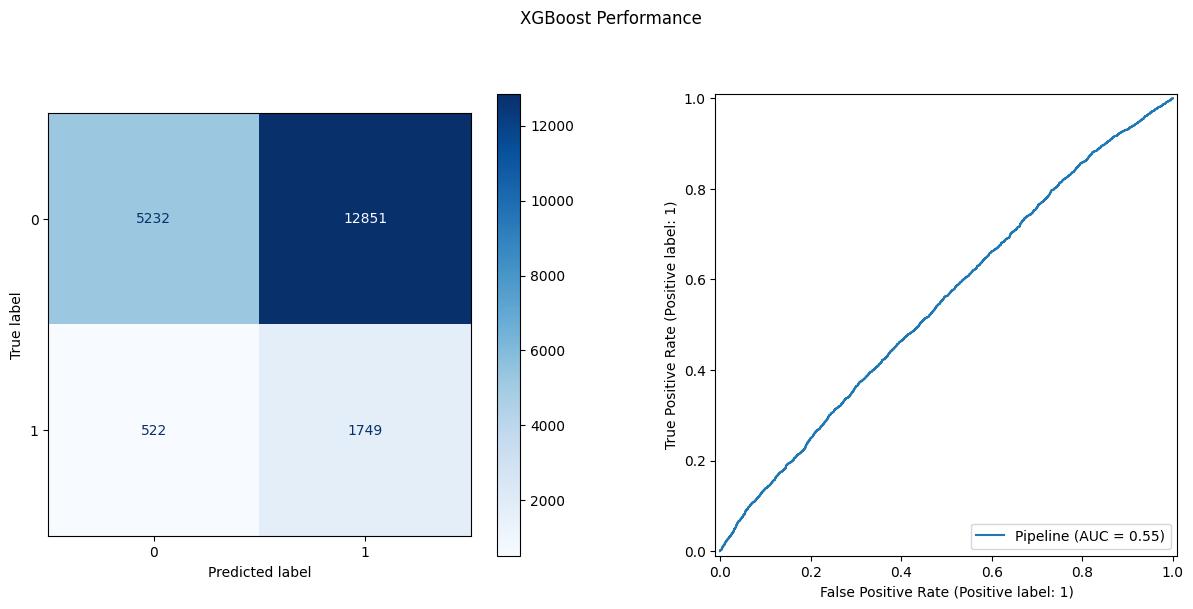


=== Final Results ===
                     Accuracy  Precision    Recall        F1   ROC AUC
XGBoost              0.342979   0.119795  0.770145  0.207338  0.529739
Logistic Regression  0.554977   0.133966  0.546896  0.215214  0.551444
Random Forest        0.825096   0.131504  0.101277  0.114428  0.508638

⭐ Deployment Recommendations:
- Recommended model: XGBoost (highest recall)
- Deployment approach:
  1. Save trained pipeline as .pkl file
  2. Integrate into hospital EMR system
  3. Automatically generate risk score when new patients are discharged
  4. High-risk patients automatically trigger follow-up by care team


In [ ]:
# -*- coding: utf-8 -*-
"""Diabetes Readmission Prediction Model """
# Authors: Junchang Yang, Chang Xue, Pardhu Mattupalli

# ========================== 1. Environment Setup ==========================
# Install dependencies (Kaggle API already included)
!pip install -q pandas numpy scikit-learn xgboost imbalanced-learn matplotlib kaggle

# ========================== 2. Auto Configure Kaggle API ==========================
import os
# Replace with your Kaggle username and API Key
os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'  # Important: Need to modify!
os.environ['KAGGLE_KEY'] = 'your_kaggle_api_key'        # Important: Need to modify!

# Auto create config file
!mkdir -p ~/.kaggle
!echo '{"username":"'$KAGGLE_USERNAME'","key":"'$KAGGLE_KEY'"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# ========================== 3. Dataset Download ==========================
print("⏳ Downloading dataset...")
!kaggle datasets download -d brandao/diabetes
!unzip -q diabetes.zip
print("✅ Dataset download completed!")

# ========================== 4. Data Loading & Validation ==========================
import pandas as pd

try:
    df = pd.read_csv('diabetic_data.csv')  # Note actual filename
    print("\n=== Data loaded successfully ===")
    print("📊 Data shape:", df.shape)
    print("🔍 First 5 rows preview:")
    print(df.head())
except Exception as e:
    print("❌ Data loading failed:", e)
    !ls -l  # Show current file list
    raise

# ========================== 5. Data Preprocessing ==========================
print("\n=== Data Preprocessing ===")

# Target variable transformation
df['readmitted'] = df['readmitted'].map({'<30': 1, '>30': 0, 'NO': 0})
print("🎯 Target variable distribution:\n", df['readmitted'].value_counts())

# Handle missing values (original data uses '?' for missing)
df = df.replace('?', pd.NA)
df = df.fillna(-1)

# ========================== 6. Feature Engineering ==========================
print("\n=== Feature Engineering ===")

# Verify actual column names
print("📝 Dataset columns:", df.columns.tolist())

# Adjusted feature list (modified based on actual columns)
features = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses',
    'age',
    'insulin',
    'diabetesMed',
    'change',
    'gender',
    'A1Cresult'
]

# Check feature existence
missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print(f"❌ Missing feature columns: {missing_features}")
    raise KeyError("Feature columns mismatch")
else:
    print("✅ All feature columns exist")

X = df[features]
y = df['readmitted']

# —— Convert all categorical features to string to avoid int/str mixed type errors ——
categorical_features = [
    'age',
    'insulin',
    'diabetesMed',
    'change',
    'gender',
    'A1Cresult'
]
X[categorical_features] = X[categorical_features].astype(str)

# ========================== 7. Data Preprocessing Pipeline ==========================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Numeric feature standardization
numeric_features = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_medications'
]

# Categorical feature encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# ========================== 8. Model Configuration ==========================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Define model collection
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(
        scale_pos_weight=sum(y == 0) / sum(y == 1),  # Handle class imbalance
        eval_metric='logloss',
        use_label_encoder=False
    )
}

# ========================== 9. Training & Evaluation ==========================
print("\n=== Model Training ===")
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

results = {}

for name, model in models.items():
    print(f"\n🚀 Training {name}...")

    # Build pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),  # Oversampling
        ('classifier', model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred)
    }
    results[name] = metrics

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0], cmap='Blues')
    RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=ax[1])
    plt.suptitle(f"{name} Performance", y=1.02)
    plt.show()

# ========================== 10. Results Display ==========================
print("\n=== Final Results ===")
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='Recall', ascending=False))

# ========================== Deployment Recommendations ==========================
print("\n⭐ Deployment Recommendations:")
best_model = results_df['Recall'].idxmax()
print(f"- Recommended model: {best_model} (highest recall)")
print("- Deployment approach:")
print("  1. Save trained pipeline as .pkl file")
print("  2. Integrate into hospital EMR system")
print("  3. Automatically generate risk score when new patients are discharged")
print("  4. High-risk patients automatically trigger follow-up by care team")